In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)

In [2]:
query = """
  WITH first_purchase AS (
    SELECT 
      user_id,
      MIN(register_dt) AS first_purchase_date
    FROM `dm.agg_user_cash_daily`
    WHERE purchase IS NOT NULL
    GROUP BY user_id
  ),

  second_purchase AS (
    SELECT 
      a.user_id,
      MIN(a.register_dt) AS second_purchase_date
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    WHERE a.purchase IS NOT NULL
      AND a.register_dt > fp.first_purchase_date
    GROUP BY a.user_id
  ),

  final AS (
    SELECT DISTINCT 
      a.user_id,
      date_diff (current_date(), join_dt, day) as join_dt,
      b.register_dt AS p_date,
      b.current_shoji AS cur_shoji,
      b.pre_shoji AS pre_shoji,
      b.pre_cash AS pre_cash,
      b.purchase AS p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = fp.first_purchase_date
    JOIN `dw.dim_airbridge_member` c 
      ON a.user_id = c.user_id
    WHERE a.register_dt <= fp.first_purchase_date
      AND b.purchase IS NOT NULL
      AND c.join_dt < "2024-12-31"
  ),

  second_purchase_data AS (
    SELECT DISTINCT 
      a.user_id,
      s.second_purchase_date,
      b.current_shoji AS second_cur_shoji,
      b.pre_shoji AS second_pre_shoji,
      b.pre_cash AS second_pre_cash,
      b.purchase AS second_p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS second_s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS second_s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN second_purchase s ON a.user_id = s.user_id
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = s.second_purchase_date
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt <= s.second_purchase_date
      AND b.purchase IS NOT NULL
  ),

  between_purchases AS (
    SELECT
      a.user_id,
      SUM(a.earn_exchange) AS between_earn_exchange,
      COUNT(a.earn_exchange) AS between_earn_exchange_cnt,
      SUM(a.earn_reward) AS between_earn_reward,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) AS between_earn_reward_cnt,
      COUNT(a.register_dt) AS between_visit_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN second_purchase sp ON a.user_id = sp.user_id
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt < sp.second_purchase_date
    GROUP BY a.user_id
  ),

  churn AS (
    SELECT 
      DISTINCT user_id, 
      is_churn
    FROM `dm.agg_user_churn_daily`
    WHERE is_churn IS TRUE
  )


  SELECT 
    a.*,
    CASE WHEN b.is_churn IS TRUE THEN TRUE ELSE FALSE END AS is_churn,
    s.second_purchase_date,
    s.second_cur_shoji,
    s.second_pre_shoji,
    s.second_pre_cash,
    s.second_p_amt,
    s.second_s_amt,
    s.second_s_rto,
    s.second_earn_exchange,
    s.second_earn_exchange_cnt,
    s.second_earn_reward,
    s.second_since_visit_dt,
    s.second_earn_reward_cnt,
    bp.between_earn_exchange,
    bp.between_earn_exchange_cnt,
    bp.between_earn_reward,
    bp.between_earn_reward_cnt,
    date_diff(s.second_purchase_date, a.p_date, day) AS days_between_purchases
  FROM (
    SELECT *
    FROM (
      SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY earn_reward_cnt DESC) AS rnk
      FROM final
    )
    WHERE rnk = 1
  ) a
  LEFT JOIN churn b ON a.user_id = b.user_id
  LEFT JOIN (
    select *
    from(
        SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY second_earn_reward_cnt DESC) AS rnk
        FROM second_purchase_data
      )
    where rnk = 1
  ) s ON a.user_id = s.user_id
  LEFT JOIN between_purchases bp ON a.user_id = bp.user_id
"""

In [3]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [4]:
from datetime import datetime as dt
ts = dt.today().strftime('%Y-%m-%d')
df.to_parquet(f'df_{ts}.parquet')


In [2]:
df = pd.read_parquet('C:\FTC_downloads\code\git\project_hct\/04-25\df_2025-04-15.parquet')

In [3]:
# 12/31 ~ 3/13 데이터 컷 (변수 삭제)
df['p_date'] = pd.to_datetime(df['p_date'])
df = df[(df['p_date'] > '2024-12-30') & (df['p_date'] <= '2025-03-13')]

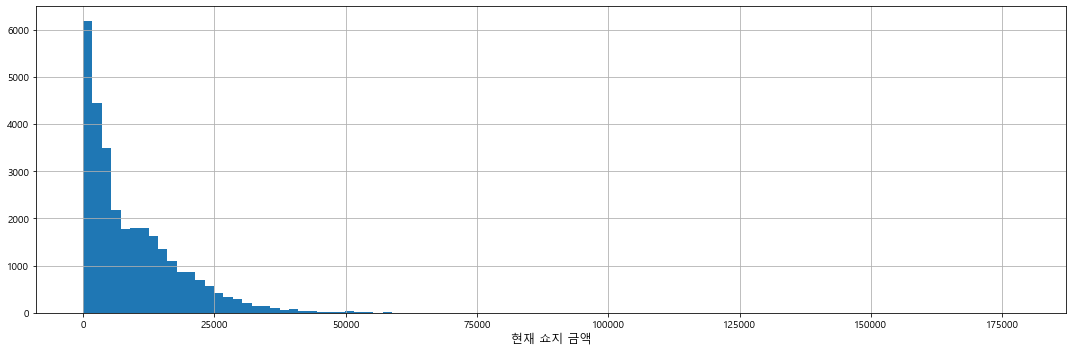

In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우 맑은 고딕 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 기존 히스토그램 그리기
plt.figure(figsize=(15, 5))
df.pre_shoji.hist(bins=100)
plt.xlabel('현재 쇼지 금액', fontsize=12)
plt.tight_layout()

### 소지 쇼지 기반 코호트

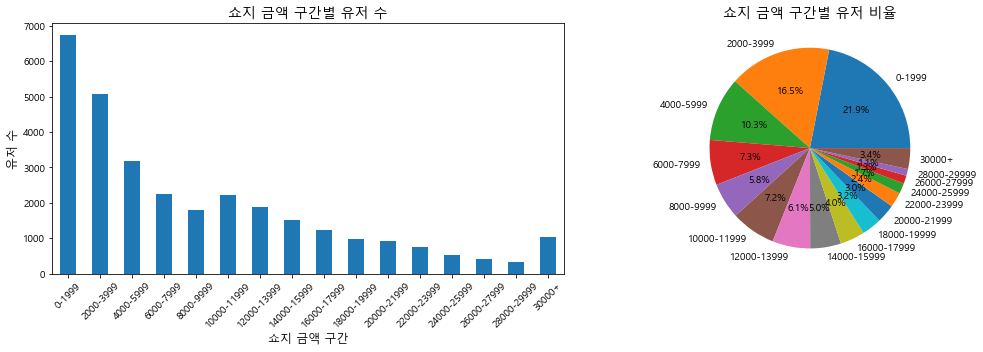

In [5]:
# pre_shoji를 2000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
bins = list(range(0, 30001, 2000)) + [float('inf')]
labels = [f'{i}-{i+1999}' for i in range(0, 30000, 2000)] + ['30000+']

# 구간화 및 각 구간별 유저 수 계산
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)
bin_counts = df['pre_shoji_bin'].value_counts().sort_index()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 첫 번째 그래프: 구간별 유저 수 막대 그래프
bin_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('쇼지 금액 구간별 유저 수', fontsize=14)
axes[0].set_xlabel('쇼지 금액 구간', fontsize=12)
axes[0].set_ylabel('유저 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 두 번째 그래프: 구간별 유저 비율 파이 차트
bin_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('쇼지 금액 구간별 유저 비율', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()


In [6]:
df['p_date'] = pd.to_datetime(df.p_date)
df.query("p_date >= '2025-01-01'").groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    # 'earn_reward_cnt': 'mean',
    'earn_reward_cnt': 'median',
    })


,user_id,pre_shoji,p_amt,s_amt,s_rto,earn_exchange,earn_reward,earn_reward_cnt
pre_shoji_bin,,,,,,,,
0-1999,6583,771.94106,15990.650160,2566.502355,0.257790,1523.90916,815.594562,15.0
2000-3999,5056,2986.77235,9997.897547,4236.930182,0.573734,2519.891416,2280.920293,31.0
4000-5999,3142,4949.440165,9064.847231,5598.914386,0.753205,4149.624443,2181.560789,30.0
6000-7999,2218,6977.018034,10505.189360,6939.034265,0.783327,5701.198828,2091.983769,31.0
8000-9999,1762,8968.698638,11633.019296,8769.167991,0.830499,7670.03689,2180.109535,34.0
10000-11999,2186,10923.768984,13662.593779,11029.327081,0.866377,10440.763495,1740.87054,29.0
12000-13999,1859,12982.646046,14927.729962,12709.480366,0.896708,12525.639053,2398.091985,44.0
14000-15999,1500,14970.046667,16097.260000,14036.600667,0.919213,14006.959333,2504.737333,44.0
16000-17999,1211,16950.326177,17147.762180,15078.754748,0.918266,15671.202312,2502.037985,45.0


<Axes: >

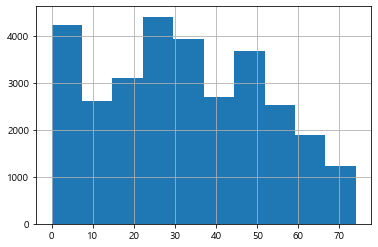

In [7]:
df.query("p_date >= '2025-01-01'").earn_reward_cnt.hist()

In [8]:
# BigQuery에서 가져온 데이터는 때때로 타입 문제가 발생할 수 있습니다.
# 'earn_reward_cnt' 열의 타입을 명시적으로 변환해 보겠습니다.
df['earn_reward_cnt'] = df['earn_reward_cnt'].astype(float)

# 참고: df = bq.query(query).to_dataframe()으로 BigQuery에서 데이터를 가져올 때
# 'unknown type object' 오류가 발생할 수 있습니다. 이는 pandas와 BigQuery 간의
# 데이터 타입 호환성 문제로 인한 것입니다.

In [9]:
df['pre_cash'] = df['pre_cash'].fillna(0)
# 5000 단위로 구간 설정
bins = list(range(0, 30001, 5000)) + [float('inf')]
labels = [f'{i}-{i+4999}' for i in range(0, 30000, 5000)] + ['30000+']

# pre_cash와 pre_shoji 모두 5000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
df['pre_cash_bin'] = pd.cut(df['pre_cash'], bins=bins, labels=labels, right=False)
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)

In [10]:
df.groupby('pre_cash_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn      pre_cash     pre_shoji         p_amt  \
               count    count          mean          mean          mean   
pre_cash_bin                                                              
0-4999         18359    18359   1000.352143  12239.643554  14489.412277   
5000-9999       4209     4209   7188.381088   5984.541934  13512.775006   
10000-14999     3620     3620  12219.232320   4843.716298  14075.055249   
15000-19999     2299     2299  17287.318399   4322.412788  14150.282732   
20000-24999     1268     1268  22140.010252   4354.234227  14952.208202   
25000-29999      596      596  27152.469799   4318.897651  16406.510067   
30000+           436      436  36296.337156   4925.123853  19265.366972   

                     s_amt     s_rto earn_exchange  earn_reward  \
                      mean      mean          mean         mean   
pre_cash_bin                                                      
0-4999        10560.633259  0.762709  11128.559617  2181.359824   
5000-9999      6367.909242  0.559332   7091.900214  1689.850796   
10000-14999    7245.626796  0.602309   6714.570442  1888.605525   
15000-19999    5847.465855  0.541866    5139.15224  2034.269682   
20000-24999    5822.530757  0.541230   5061.930599   2128.36041   
25000-29999    5283.857383  0.512483   4624.104027  2140.065436   
30000+         5727.543578  0.514656   4780.768349  2327.444954   

             earn_reward_cnt             
                      median       mean  
pre_cash_bin                             
0-4999                  34.0  34.362819  
5000-9999               27.0  26.533618  
10000-14999             28.0  28.621547  
15000-19999             29.0  29.075250  
20000-24999             29.0  28.545741  
25000-29999             28.0  26.488255  
30000+                  28.5  25.977064

In [11]:
df.groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn     pre_cash     pre_shoji         p_amt  \
                count    count         mean          mean          mean   
pre_shoji_bin                                                             
0-4999          13392    13392  9895.556900   2035.696013  12937.554510   
5000-9999        5623     5623  5258.056553   7166.800285  10520.218744   
10000-14999      4867     4867  3435.326279  12280.850832  14514.561331   
15000-19999      2957     2957  2077.179574  17248.104498  17236.070342   
20000-24999      1946     1946  2019.301644  22218.921377  20296.145940   
25000-29999       973      973  1396.367934  27272.252826  22116.998972   
30000+           1033     1033  2363.447241   38274.03485  27595.914811   

                      s_amt     s_rto earn_exchange  earn_reward  \
                       mean      mean          mean         mean   
pre_shoji_bin                                                      
0-4999          3511.099686  0.432879   2143.757467  1553.934961   
5000-9999       7186.884937  0.789337   6041.804731  2036.113463   
10000-14999    12114.012739  0.886141  11799.460242  2112.645161   
15000-19999    15254.692594  0.923280  16148.172134  2526.596212   
20000-24999    18207.320658  0.933428  21489.023124  2831.808325   
25000-29999    20413.100719  0.947934  26508.767729  3375.463515   
30000+         25771.823814  0.953272   44621.24879  4709.725073   

              earn_reward_cnt             
                       median       mean  
pre_shoji_bin                             
0-4999                   26.0  25.329600  
5000-9999                30.0  32.268718  
10000-14999              37.0  34.969180  
15000-19999              45.0  39.502198  
20000-24999              48.0  41.916238  
25000-29999              51.0  47.063720  
30000+                   49.0  40.081317

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
# 메모리 사용량 확인
import psutil
import os

# 현재 프로세스의 메모리 사용량 확인
process = psutil.Process(os.getpid())
memory_info = process.memory_info()
print(f"메모리 사용량: {memory_info.rss / 1024 / 1024:.2f} MB")

# 시스템 전체 메모리 상태 확인
system_memory = psutil.virtual_memory()
print(f"시스템 전체 메모리: {system_memory.total / 1024 / 1024 / 1024:.2f} GB")
print(f"사용 가능한 메모리: {system_memory.available / 1024 / 1024 / 1024:.2f} GB")
print(f"메모리 사용률: {system_memory.percent}%")

# CPU 사용량 확인
cpu_percent = psutil.cpu_percent(interval=1)
print(f"CPU 사용률: {cpu_percent}%")

# 각 CPU 코어별 사용량
cpu_percent_per_core = psutil.cpu_percent(interval=1, percpu=True)
for i, percent in enumerate(cpu_percent_per_core):
    print(f"CPU 코어 {i}: {percent}%")

메모리 사용량: 234.50 MB
시스템 전체 메모리: 31.77 GB
사용 가능한 메모리: 16.63 GB
메모리 사용률: 47.6%
CPU 사용률: 8.0%
CPU 코어 0: 7.7%
CPU 코어 1: 3.1%
CPU 코어 2: 0.0%
CPU 코어 3: 27.3%
CPU 코어 4: 13.8%
CPU 코어 5: 0.0%
CPU 코어 6: 14.1%
CPU 코어 7: 1.6%
CPU 코어 8: 15.6%
CPU 코어 9: 0.0%
CPU 코어 10: 16.9%
CPU 코어 11: 0.0%
CPU 코어 12: 9.4%
CPU 코어 13: 7.8%
CPU 코어 14: 0.0%
CPU 코어 15: 3.1%
CPU 코어 16: 12.1%
CPU 코어 17: 4.7%
CPU 코어 18: 1.6%
CPU 코어 19: 25.0%


In [14]:
df.sample(1)

,user_id,join_dt,p_date,cur_shoji,pre_shoji,pre_cash,p_amt,s_amt,s_rto,earn_exchange,earn_exchange_cnt,earn_reward,since_visit_dt,earn_reward_cnt,rnk,is_churn,second_purchase_date,second_cur_shoji,second_pre_shoji,second_pre_cash,second_p_amt,second_s_amt,second_s_rto,second_earn_exchange,second_earn_exchange_cnt,second_earn_reward,second_since_visit_dt,second_earn_reward_cnt,between_earn_exchange,between_earn_exchange_cnt,between_earn_reward,between_earn_reward_cnt,days_between_purchases,pre_shoji_bin,pre_cash_bin
19697,0b002ed3-ac99-40bd-aef5-748f27ea6dd7,377,2025-02-21,10,17746,91.0,29400.0,17836,0.61,15700,52,2056,52,51.0,1,True,NaT,<NA>,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15000-19999,0-4999


In [15]:
df['is_first_bankrupt'] = df.cur_shoji < 5
df[['is_first_bankrupt','cur_shoji','p_amt','s_amt']].sample(10)

,is_first_bankrupt,cur_shoji,p_amt,s_amt
1209,False,673,9900.0,9900
40961,False,111,23900.0,12000
26417,False,5457,4800.0,4800
9825,False,7,31800.0,17812
8418,True,0,3900.0,2593
17283,True,0,4980.0,988
9314,True,0,17400.0,17224
41393,True,0,14900.0,13985
37202,True,0,19800.0,17186
48122,False,996,7800.0,390


In [16]:
df.groupby(['pre_shoji_bin','pre_cash_bin']).agg({
    'join_dt': ['median','mean','min','max'],
    'user_id': 'count',
    'is_first_bankrupt': 'sum',
    'is_churn': 'sum',
    "second_cur_shoji" :'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean','max'],
    }).reset_index()


pre_shoji_bin pre_cash_bin join_dt                         user_id  \
                               median        mean   min   max   count   
0         0-4999       0-4999   565.0  551.001926   106   839    4674   
1         0-4999    5000-9999   570.5   567.03271   149   823    2782   
2         0-4999  10000-14999   576.0  577.942723   171   837    2549   
3         0-4999  15000-19999   580.0  584.045957   252   818    1719   
4         0-4999  20000-24999   582.5  586.856681   291   820     928   
5         0-4999  25000-29999   591.5  597.696759   309   809     432   
6         0-4999       30000+   588.0  595.905537   257   838     307   
7      5000-9999       0-4999   574.0  560.390681   107   821    3906   
8      5000-9999    5000-9999   573.0  560.528265   191   805     513   
9      5000-9999  10000-14999   569.5       570.6   217   824     460   
10     5000-9999  15000-19999   582.5  591.873494   245   815     332   
11     5000-9999  20000-24999   565.0  582.859903   349   811     207   
12     5000-9999  25000-29999   612.0  606.681034   402   809     116   
13     5000-9999       30000+   594.0  588.413793   334   777      87   
14   10000-14999       0-4999   574.0  567.805344   121   839    3668   
15   10000-14999    5000-9999   580.5  579.590196   173   838     510   
16   10000-14999  10000-14999   582.5  585.246411   288   817     418   
17   10000-14999  15000-19999   581.0  586.686667   294   793     150   
18   10000-14999  20000-24999   587.0  589.179487   389   805      78   
19   10000-14999  25000-29999   586.0  584.428571   407   771      28   
20   10000-14999       30000+   611.0  618.666667   400   757      15   
21   15000-19999       0-4999   572.0   573.12333   212   822    2619   
22   15000-19999    5000-9999   562.0  564.722628   310   805     137   
23   15000-19999  10000-14999   562.0  576.821053   324   820      95   
24   15000-19999  15000-19999   619.0  607.156863   344   805      51   
25   15000-19999  20000-24999   634.0  621.424242   456   799      33   
26   15000-19999  25000-29999   617.0  568.666667   205   778      12   
27   15000-19999       30000+   578.0  622.444444   443   794       9   
28   20000-24999       0-4999   574.5  573.754706   270   820    1700   
29   20000-24999    5000-9999   589.0  598.725926   321   785     135   
30   20000-24999  10000-14999   613.5  612.741935   380   811      62   
31   20000-24999  15000-19999   616.0  627.461538   444   803      26   
32   20000-24999  20000-24999   638.5       618.6   371   769      10   
33   20000-24999  25000-29999   595.5       610.0   464   785       4   
34   20000-24999       30000+   609.0  588.888889   380   752       9   
35   25000-29999       0-4999   577.0  583.703744   256   819     908   
36   25000-29999    5000-9999   607.0  589.206897   341   805      29   
37   25000-29999  10000-14999   615.0  633.058824   513   784      17   
38   25000-29999  15000-19999   604.0       600.1   410   751      10   
39   25000-29999  20000-24999   659.0  636.571429   572   684       7   
40   25000-29999  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
41   25000-29999       30000+   667.0       667.0   561   773       2   
42        30000+       0-4999   583.5  591.486425   118   838     884   
43        30000+    5000-9999   579.0  591.747573   266   801     103   
44        30000+  10000-14999   639.0  628.105263   482   739      19   
45        30000+  15000-19999   586.0  608.727273   503   759      11   
46        30000+  20000-24999   609.0       649.4   516   797       5   
47        30000+  25000-29999   579.5      582.75   562   610       4   
48        30000+       30000+   559.0       540.0   465   596       7   

   is_first_bankrupt is_churn second_cur_shoji      pre_cash     pre_shoji  \
                 sum      sum            count          mean          mean   
0               2074     2467             1008   1781.715233   2169.418057   
1               1056     1076             103

In [17]:
df.groupby("earn_reward_cnt").agg({
    "user_id":'count',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    }).reset_index()


,earn_reward_cnt,user_id,is_first_bankrupt,is_churn,second_cur_shoji,earn_reward,earn_exchange,p_amt,s_amt,s_rto
0,0.0,372,266,332,46,0.0,8085.077957,14846.397849,7058.091398,0.574005
1,1.0,792,276,572,179,478.670455,11380.606061,16759.823232,7850.958333,0.545960
2,2.0,835,243,464,285,719.05988,11869.620359,16808.323353,8035.032335,0.538623
3,3.0,662,178,378,231,605.706949,10075.495468,17082.567976,7321.273414,0.497689
4,4.0,567,168,334,186,398.061728,9566.87478,16937.601411,7028.989418,0.518395
5,5.0,512,157,281,162,642.085938,9019.222656,16575.722656,7166.070312,0.493633
6,6.0,495,143,252,186,745.862626,9951.030303,17335.212121,7351.523232,0.496808
7,7.0,460,153,226,161,577.715217,8595.717391,16011.891304,6643.593478,0.486891
8,8.0,351,97,188,129,732.911681,8122.088319,16536.524217,6653.336182,0.522365
9,9.0,367,124,190,117,645.967302,6986.871935,17089.455041,6309.904632,0.504387


리워드 획득 횟수 통계:
평균: 31.71
중앙값: 30.00
최소값: 0.00
최대값: 74.00


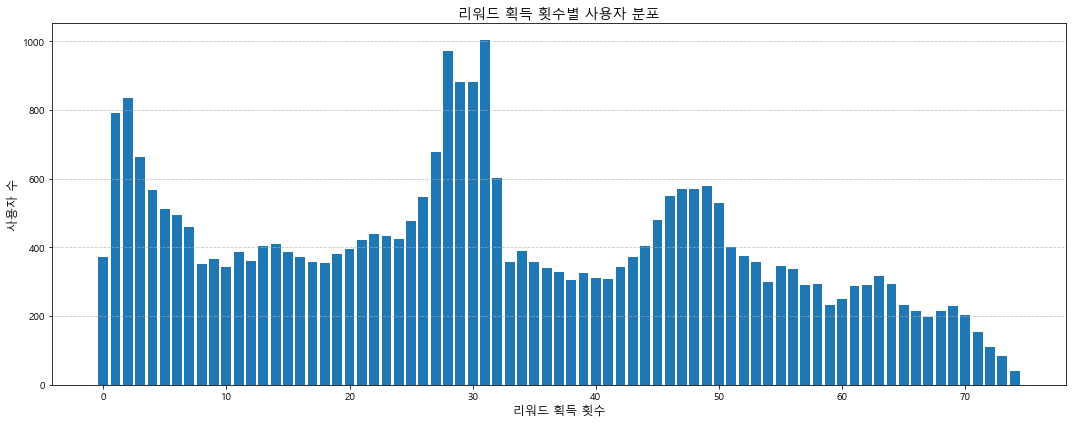

In [18]:
# 리워드 획득 횟수별 사용자 분포 분석
distribution_df = df.groupby("earn_reward_cnt")["user_id"].count().reset_index()
distribution_df = distribution_df.sort_values("earn_reward_cnt")

# 시각화 개선
plt.figure(figsize=(15, 6))
plt.bar(distribution_df["earn_reward_cnt"], distribution_df["user_id"])
plt.title("리워드 획득 횟수별 사용자 분포", fontsize=14)
plt.xlabel("리워드 획득 횟수", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 기본 통계량 출력
print("리워드 획득 횟수 통계:")
print(f"평균: {df['earn_reward_cnt'].mean():.2f}")
print(f"중앙값: {df['earn_reward_cnt'].median():.2f}")
print(f"최소값: {df['earn_reward_cnt'].min():.2f}")
print(f"최대값: {df['earn_reward_cnt'].max():.2f}")

In [19]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,pre_cash,cur_shoji,is_first_bankrupt,is_churn,second_cur_shoji,earn_exchange,p_amt,s_amt,s_rto
0,0-4999,10960,9287.678650,306.336953,4440,4570,4078,702.442153,13375.925182,2561.049818,0.349870
1,5000-9999,5981,5387.210500,595.130079,2518,2633,1662,5178.921919,9866.779803,6491.896338,0.776046
2,10000-14999,5552,5735.918948,1224.277918,1986,2232,1189,10129.072947,13605.434078,10997.949388,0.870648
3,15000-19999,3308,2860.399335,2440.538996,871,1126,618,14714.605502,16565.716445,14427.78688,0.913265
4,20000-24999,2245,3483.663252,4250.653452,429,601,548,19443.447661,19344.881960,17171.58931,0.926129
5,25000-29999,1160,2622.676724,6513.456034,185,264,318,23904.225862,21307.827586,19430.410345,0.940241
6,30000-34999,602,3547.109635,8101.503322,72,120,206,28945.872093,23019.617940,21339.29402,0.948056
7,35000-39999,292,3017.006849,9870.236301,28,69,108,33905.089041,23839.657534,22500.715753,0.955068
8,40000-44999,186,5138.102151,8253.951613,27,33,84,35108.790323,24405.161290,22424.247312,0.940968
9,45000-49999,100,4422.220000,13037.14,8,20,49,43616.32,22672.900000,20774.65,0.942600


In [27]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'pre_shoji', 'pre_cash',
       'p_amt', 's_amt', 's_rto', 'earn_exchange', 'earn_exchange_cnt',
       'earn_reward', 'since_visit_dt', 'earn_reward_cnt', 'rnk', 'is_churn',
       'second_purchase_date', 'second_cur_shoji', 'second_pre_shoji',
       'second_pre_cash', 'second_p_amt', 'second_s_amt', 'second_s_rto',
       'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'first_cum_money', 'first_cum_money_bin',
       'second_p_amt_bin'],
      dtype='object')

In [20]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    # "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    "second_cur_shoji":'count',
    "earn_reward_cnt":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,cur_shoji,is_first_bankrupt,is_churn,earn_exchange,p_amt,s_amt,s_rto,second_cur_shoji,earn_reward_cnt,second_earn_reward,second_earn_exchange,second_earn_reward_cnt,second_p_amt,second_s_amt,second_s_rto
0,0-4999,10960,306.336953,4440,4570,702.442153,13375.925182,2561.049818,0.349870,4078,22.649453,1649.67999,6439.033595,25.922266,14971.275135,6928.964689,0.579598
1,5000-9999,5981,595.130079,2518,2633,5178.921919,9866.779803,6491.896338,0.776046,1662,32.074904,2014.149819,8337.058965,27.33574,12101.756919,8899.457882,0.799687
2,10000-14999,5552,1224.277918,1986,2232,10129.072947,13605.434078,10997.949388,0.870648,1189,35.661203,1350.867115,5784.894029,19.52397,11606.148024,8390.408747,0.785803
3,15000-19999,3308,2440.538996,871,1126,14714.605502,16565.716445,14427.78688,0.913265,618,40.553809,1464.446602,2611.613269,20.514563,11603.042071,8242.333333,0.807120
4,20000-24999,2245,4250.653452,429,601,19443.447661,19344.881960,17171.58931,0.926129,548,42.582628,1406.427007,2342.631387,19.478102,12613.868613,9661.060219,0.822372
5,25000-29999,1160,6513.456034,185,264,23904.225862,21307.827586,19430.410345,0.940241,318,47.089655,1623.433962,1788.333333,20.827044,15498.207547,11925.981132,0.836101
6,30000-34999,602,8101.503322,72,120,28945.872093,23019.617940,21339.29402,0.948056,206,44.294020,1693.606796,2057.053398,22.271845,16394.660194,12911.043689,0.861214
7,35000-39999,292,9870.236301,28,69,33905.089041,23839.657534,22500.715753,0.955068,108,42.380137,1414.75,2064.814815,21.074074,16830.370370,13564.537037,0.882037
8,40000-44999,186,8253.951613,27,33,35108.790323,24405.161290,22424.247312,0.940968,84,27.526882,12386.083333,4329.988095,21.130952,23308.333333,20429.904762,0.872976
9,45000-49999,100,13037.14,8,20,43616.32,22672.900000,20774.65,0.942600,49,32.410000,3698.693878,3112.714286,22.979592,17593.877551,15074.510204,0.884898


In [21]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'pre_shoji', 'pre_cash',
       'p_amt', 's_amt', 's_rto', 'earn_exchange', 'earn_exchange_cnt',
       'earn_reward', 'since_visit_dt', 'earn_reward_cnt', 'rnk', 'is_churn',
       'second_purchase_date', 'second_cur_shoji', 'second_pre_shoji',
       'second_pre_cash', 'second_p_amt', 'second_s_amt', 'second_s_rto',
       'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'first_cum_money', 'first_cum_money_bin'],
      dtype='object')

In [ ]:
# float 타입 오류 수정
# NaN 값을 제외하고 최대값 계산
max_value = df["second_p_amt"].dropna().max()
if pd.notna(max_value):
    max_int = int(max_value) + 5001
    # 레이블 개수는 구간 경계 개수보다 하나 적어야 함
    bins = list(range(0, max_int, 5000))
    labels = [f"{i}-{i+4999}" for i in range(0, max_int, 5000) if i < max_int - 5000]
    df["second_p_amt_bin"] = pd.cut(df["second_p_amt"], 
                                    bins=bins,
                                    labels=labels,
                                    right=False)
else:
    # 데이터가 없는 경우 빈 카테고리 생성
    df["second_p_amt_bin"] = pd.Categorical([])

df.groupby("second_p_amt_bin").agg({
    "user_id":'count',
    "second_pre_shoji":'mean',
    "second_pre_cash":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    }).reset_index()

,second_p_amt_bin,user_id,second_pre_shoji,second_pre_cash,is_first_bankrupt,second_p_amt,second_s_amt,second_s_rto,second_earn_reward,second_earn_exchange,second_earn_reward_cnt
0,0-4999,1499,5204.022015,2896.817321,271,4031.754503,3508.169446,0.871888,1552.324883,2254.971314,24.06938
1,5000-9999,2226,7757.842767,3732.877281,489,7912.421384,5904.610063,0.758580,1644.026056,4299.430368,24.544474
2,10000-14999,2507,9659.036697,4721.584306,647,12397.088153,8467.269246,0.683450,1645.284803,5834.209414,24.069007
3,15000-19999,1399,12809.837026,4229.359420,349,17396.854896,11931.136526,0.689843,1630.067906,8212.057184,24.102931
4,20000-24999,563,15052.150977,4391.007220,158,22232.699822,14096.412078,0.633996,1650.387211,10101.856128,24.209591
5,25000-29999,349,15670.762178,5137.967359,89,27672.636103,15257.246418,0.554241,2391.323782,9923.068768,27.025788
6,30000-34999,196,15415.729592,5371.649485,60,32661.224490,15308.071429,0.469490,2941.836735,7917.688776,22.709184
7,35000-39999,121,15927.190083,7150.358333,17,37807.024793,15572.61157,0.410744,3585.22314,8668.578512,21.471074
8,40000-44999,50,16156.22,8588.479167,13,42512.000000,16009.88,0.379600,4996.0,6558.28,17.36
9,45000-49999,32,17925.15625,7482.500000,7,47903.125000,18232.90625,0.376563,11490.25,5734.71875,11.4375
